<a href="https://colab.research.google.com/github/my000own000files1/Fuzzy/blob/controll/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подъемно-транспортный механизм с двумя степенями свободы перемещаемого груза:  

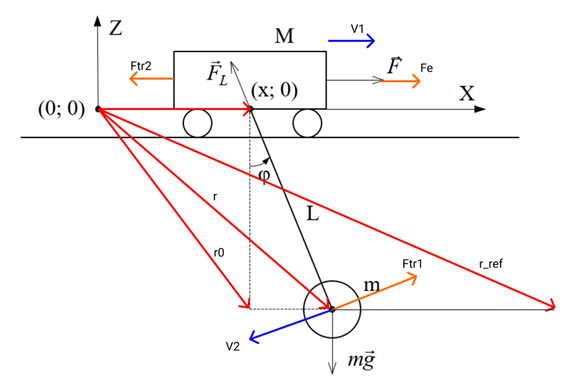

Простейшая модель крана представляет собой маятник на каретке.
Параметры модели: L — длина троса; M — масса тележки; m — масс; груза; φ — угол отклонения груза; x — расстояние от центра оси до точки подвеса груза;   — сила, создаваемая электроприводом, действующая на тележку;   — сила, действующая на трос с грузом со стороны электропри-вода подъема;  — радиус-векторы положения центра груза началь-ный, текущий, заданный соответственно;   — сила вязкого трения о воз-дух груза;  — сила вязкого трения о воздух каретки.


In [15]:
# Автоматизация расчета уравнения состояния объекта с помощью пакета sympy
import sympy,math

#создаем символьные переменные
m=sympy.symbols('m')
M=sympy.symbols('M')
g=sympy.symbols('g')
L=sympy.symbols('L')
k1=sympy.symbols('k1')
k2=sympy.symbols('k2')
Fe=sympy.symbols('Fe')
x=sympy.symbols('x')
dx=sympy.symbols('dx')
phi=sympy.symbols('phi')
dphi=sympy.symbols('dphi')

ddx=sympy.symbols('ddx')
ddphi=sympy.symbols('ddphi')
#signdx=sympy.symbols('np.sign(dx)')

# полная кинетическая системы T
T = m*(dx**2+(L**2)*dphi**2+2*dx*L*dphi*sympy.cos(phi))/2+M*(dx**2)/2
# полная потенциальная энергися системы V
V = (k1*(L*dphi)*sympy.sin(phi)-m*g)*L*sympy.cos(phi)
#задание функции Лагранжа
L = T - V
print("L=",L)
#правая часть 1-ого уравнения ЭЛ
Fx=Fe-k2*dx 
#Система уравнений Эйлера-Лагранжа 2 рода
dLddx=sympy.diff(L,dx)
print(dLddx)
L1=(sympy.diff(dLddx,x)*dx+sympy.diff(dLddx,dx)*ddx+sympy.diff(dLddx,phi)*dphi+sympy.diff(dLddx,dphi)*ddphi)-(sympy.diff(L,x))-Fx #L[0]=0
print("L1=",L1,"=0")
dLddphi=sympy.diff(L,dphi)
print("dL/d(dphi)=",dLddphi)
dLdphi=sympy.diff(L,phi)
print("dLdphi=",dLdphi)
ddLddphidt=(sympy.diff(dLddphi,x)*dx+sympy.diff(dLddphi,dx)*ddx+sympy.diff(dLddphi,phi)*dphi+sympy.diff(dLddphi,dphi)*ddphi)
print("d( dL/d(dphi) )/dt=",ddLddphidt)
L2=ddLddphidt-dLdphi +k1*dphi*L*sympy.cos(phi) #L[1]=0
print("L2=",L2,"=0")
ddphi=sympy.solve(L2,ddphi)
print("ddphi=",ddphi,"\n")
ddx=sympy.solve(L1.subs('ddphi',ddphi[0]),ddx)
ddx = sympy.simplify(ddx[0])
ddphi=ddphi[0]
print("ddx=",ddx,"\n","ddphi=",ddphi)

L= -L*(L*dphi*k1*sin(phi) - g*m)*cos(phi) + M*dx**2/2 + m*(L**2*dphi**2 + 2*L*dphi*dx*cos(phi) + dx**2)/2
M*dx + m*(2*L*dphi*cos(phi) + 2*dx)/2
L1= -Fe + L*ddphi*m*cos(phi) - L*dphi**2*m*sin(phi) + ddx*(M + m) + dx*k2 =0
dL/d(dphi)= -L**2*k1*sin(phi)*cos(phi) + m*(2*L**2*dphi + 2*L*dx*cos(phi))/2
dLdphi= -L**2*dphi*k1*cos(phi)**2 - L*dphi*dx*m*sin(phi) + L*(L*dphi*k1*sin(phi) - g*m)*sin(phi)
d( dL/d(dphi) )/dt= L**2*ddphi*m + L*ddx*m*cos(phi) + dphi*(L**2*k1*sin(phi)**2 - L**2*k1*cos(phi)**2 - L*dx*m*sin(phi))
L2= L**2*ddphi*m + L**2*dphi*k1*cos(phi)**2 + L*ddx*m*cos(phi) + L*dphi*dx*m*sin(phi) - L*(L*dphi*k1*sin(phi) - g*m)*sin(phi) + dphi*k1*(-L*(L*dphi*k1*sin(phi) - g*m)*cos(phi) + M*dx**2/2 + m*(L**2*dphi**2 + 2*L*dphi*dx*cos(phi) + dx**2)/2)*cos(phi) + dphi*(L**2*k1*sin(phi)**2 - L**2*k1*cos(phi)**2 - L*dx*m*sin(phi)) =0
ddphi= [-dphi**3*k1*cos(phi)/2 + dphi**2*k1**2*sin(phi)*cos(phi)**2/m - ddx*cos(phi)/L - dphi**2*dx*k1*cos(phi)**2/L - dphi*g*k1*cos(phi)**2/L - g*sin(phi)/L - M*

In [16]:
#парсер в нужный формат Latex
def pars_Tex(u_str):
    import string
    u_str=str(u_str.evalf(2))
    u_str=u_str.replace("**","^")
    u_str=u_str.replace("phi","\phi")
    u_str=u_str.replace("ddphi","\ddot{\phi}")
    u_str=u_str.replace("dphi","\dot{\phi}")
    u_str=u_str.replace("ddx","\ddot{x}")
    u_str=u_str.replace("dx","\dot{x}")
    u_str=u_str.replace("k1","k_1")
    u_str=u_str.replace("k_2","k_2")
    u_str=u_str.replace("Fe","F_e")
    print(u_str)

In [17]:
pars_Tex(ddx)

(F_e*L + 0.5*L^2*d\phi^3*k_1*m*cos(\phi)^2 - L^2*d\phi^2*k_1^2*sin(\phi)*cos(\phi)^3 + L^2*d\phi^2*m*sin(\phi) + L*d\phi^2*\dot{x}*k_1*m*cos(\phi)^3 + L*d\phi*g*k_1*m*cos(\phi)^3 - L*\dot{x}*k2 + 0.5*L*g*m*sin(2*\phi) + 0.5*M*d\phi*\dot{x}^2*k_1*cos(\phi)^2 + 0.5*d\phi*\dot{x}^2*k_1*m*cos(\phi)^2)/(L*(M + m*sin(\phi)^2))


In [18]:
pars_Tex(ddphi)

-0.5*d\phi^3*k_1*cos(\phi) + d\phi^2*k_1^2*sin(\phi)*cos(\phi)^2/m - \ddot{x}*cos(\phi)/L - d\phi^2*\dot{x}*k_1*cos(\phi)^2/L - d\phi*g*k_1*cos(\phi)^2/L - g*sin(\phi)/L - 0.5*M*d\phi*\dot{x}^2*k_1*cos(\phi)/(L^2*m) - 0.5*d\phi*\dot{x}^2*k_1*cos(\phi)/L^2


\begin{cases} \ddot{x}=(F_e*L + 0.5*L^2*d\phi^3*k_1*m*cos(\phi)^2 - L^2*d\phi^2*k_1^2*sin(\phi)*cos(\phi)^3 + L^2*d\phi^2*m*sin(\phi) + L*d\phi^2*\dot{x}*k_1*m*cos(\phi)^3 + L*d\phi*g*k_1*m*cos(\phi)^3 - L*\dot{x}*k2 + 0.5*L*g*m*sin(2*\phi) + 0.5*M*d\phi*\dot{x}^2*k_1*cos(\phi)^2 + 0.5*d\phi*\dot{x}^2*k_1*m*cos(\phi)^2)/(L*(M + m*sin(\phi)^2)) \\
 \ddot{\phi}=-0.5*d\phi^3*k_1*cos(\phi) + d\phi^2*k_1^2*sin(\phi)*cos(\phi)^2/m - \ddot{x}*cos(\phi)/L - d\phi^2*\dot{x}*k_1*cos(\phi)^2/L - d\phi*g*k_1*cos(\phi)^2/L - g*sin(\phi)/L - 0.5*M*d\phi*\dot{x}^2*k_1*cos(\phi)/(L^2*m) - 0.5*d\phi*\dot{x}^2*k_1*cos(\phi)/L^2 \end{cases}

In [19]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 3.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=49bb487ac0c7184a927e8e7616adb0ee433c2efc92ed6c54fbf0e426516514f0
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [20]:
  !pip install -U control

     |████████████████████████████████| 348kB 3.8MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344929 sha256=c2bb7c1cb9520d6d3070836147a6585d25ef7bdf80308c3278beb51155acc462
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [21]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control as ct
from control.matlab import * #I want to have a MATLAB-like environment
import matplotlib.pyplot as plt
import scipy as sp

In [22]:
#creating object dynamics
def port_crane_updfcn(t,s,u,params):
  """A port crane with a cargo on a rope dynamics (like object) 
  assumptions: by all perturbations such as the rolling friction
   force at the point of contact with the rails, air resistance,
    we also assume that the cable is inextensible, i.e. L=const

  Parameters
  ----------
  s: array 
      System state: [x,dx,phi,dphi], where x is a port crane (object) position
      in [0,200] [m], dx is velocity of the port crane in m/s, phi is an angle
      of deflection of the rope with a container, which is a cargo and attached
      to the end of the rope in rad, dphi is angular velocity of the rope 
      deflection in rad/sec

  u: array
      System inputs: [Fe], where Fe is a pulling force exerted on the
      trolley (cart), created by electric motor in Newton

  Returns 
  -------
  float
      [ddx,ddphi], where ddx is a port crane acceleration in m/s^2 and ddphi is 
      angular acceleration in rad/s^2
  """
  from math import sin,cos

  # Set up the system parameters
  m = params.get('m', 400.)  # cargo mass in kg
  M = params.get('M', 3000.) # port crane mass in kg
  g = params.get('g', 9.8)    # gravitational constant, m/s^2
  L = params.get('L', 30.)     # length of the drope in m
  k1 = params.get('k1', 8e-1)    # static coefficient of viscous friction air acting on port crane cart in 1/kg
  k2 = params.get('k2',1.5e3)     # static coefficient of friction acting on cargo, it's include viscous friction air and dry friction and other that depend on speed in 1/kg

  # Define variables for object state
  x = s[0]    # port crane position in m
  dx = s[1]   # velocity of the port crane in m/s
  phi = s[2]  # deflection of the rope angle in rad
  dphi = s[3] # angular velocity of the rope deflection in rad/sec

  #Define variables for object inputs
  Fe = u[0]   # pulling force exerted on the trolley in Newtons

  # calculating the output variables
  ddx = (Fe*L + L**2*dphi**3*k1*m*cos(phi)**2/2 - L**2*dphi**2*k1**2*sin(phi)*cos(phi)**3 + L**2*dphi**2*m*sin(phi) + L*dphi**2*dx*k1*m*cos(phi)**3 + L*dphi*g*k1*m*cos(phi)**3 - L*dx*k2 + L*g*m*sin(2*phi)/2 + M*dphi*dx**2*k1*cos(phi)**2/2 + dphi*dx**2*k1*m*cos(phi)**2/2)/(L*(M + m*sin(phi)**2)) 
  ddphi = -dphi**3*k1*cos(phi)/2 + dphi**2*k1**2*sin(phi)*cos(phi)**2/m - ddx*cos(phi)/L - dphi**2*dx*k1*cos(phi)**2/L - dphi*g*k1*cos(phi)**2/L - g*sin(phi)/L - M*dphi*dx**2*k1*cos(phi)/(2*L**2*m) - dphi*dx**2*k1*cos(phi)/(2*L**2)

  return np.array([dx,ddx,dphi,ddphi])

def port_crane_outfcn(t, s, u, params):
  return s[0:4]

In [23]:
# Define a generator for creating a plots
def system_dynamic_plot(sys, t, y, u, t_start_input=0, x_ref=0, linetype='b-',
                         subplots=[None, None, None],fig_size=None):
  #Figure out the plot bounds and indices
  x_min = 0; x_max = x_ref+math.ceil(x_ref*0.05); x_ind = sys.find_state('x')
  phi_min = -math.pi/18; phi_max = math.pi/18; phi_ind = sys.find_state('phi')
  Fe_min = 0; Fe_max = max(u); Fe_ind = sys.find_input('Fe') 

  #convert phi from rad to deg
  from math import pi 
  y[phi_ind]=y[phi_ind]*180/pi

  # Make sure the upper and lower bounds on x are OK
  while max(y[x_ind]) > x_max: x_max += 1
  while min(y[x_ind]) < x_min: x_min -= 1

  # Make sure the upper and lower bounds on phi are OK
  while max(y[phi_ind]) > phi_max: phi_max += 1
  while min(y[phi_ind]) < phi_min: phi_min -= 1
  phi_max+=1
  phi_min-=1

  # Make sure the upper and lower bounds on Fe are OK
  if len(u.shape)>1:
    while max(u[Fe_ind]) > Fe_max: Fe_max += 1
    while min(u[Fe_ind]) < Fe_min: Fe_min -= 1
  else:
    while max(u) > Fe_max: Fe_max += 1
    while min(u) < Fe_min: Fe_min -= 1
  Fe_max += Fe_max*0.1

  # Create arrays for return values
  subplot_axes = subplots.copy()

  # Position profile
  if subplot_axes[0] is None:
    subplot_axes[0] = plt.subplot(3,1,1)
  else:
    plt.sca(subplots[0])
  plt.plot(t, y[x_ind], linetype)
  plt.plot(t, x_ref*np.ones(t.shape), 'k-')
  plt.plot([t_start_input, t_start_input], [x_min, x_max], 'k--')
  plt.axis([0, t[-1], x_min, x_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('Port crane \nposition $x$')
  plt.grid(color='0.5')
  
  # Angle phi profile
  if subplot_axes[1] is None:
    subplot_axes[1] = plt.subplot(3,1,2)
  else:
    plt.sca(subplots[1])
  plt.plot(t, y[phi_ind], linetype)
  plt.plot([t_start_input, t_start_input], [phi_min, phi_max], 'k--')
  plt.axis([0, t[-1], phi_min, phi_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('deflection of the\n rope angle\n $\phi$ in $\circ$')
  plt.grid(color='0.5')

  # Pulling force
  if subplot_axes[2] is None:
    subplot_axes[2] = plt.subplot(3,1,3)
  else:
    plt.sca(subplots[2])
  if len(u.shape)>1:
    plt.plot(t, u[Fe_ind], linetype)
  else:
    plt.plot(t, u, linetype)
  plt.plot([t_start_input, t_start_input], [Fe_min, Fe_max], 'k--')
  plt.axis([0, t[-1], Fe_min, Fe_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('pulling force Fe,\n $Newton$')
  plt.grid(color='0.5')
  
  return subplot_axes

# State space fuzzy-controller

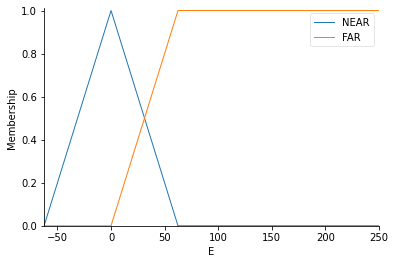

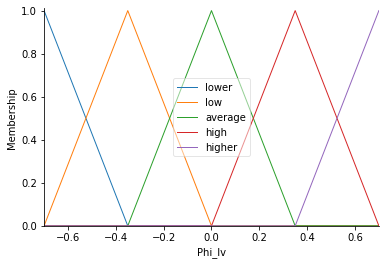

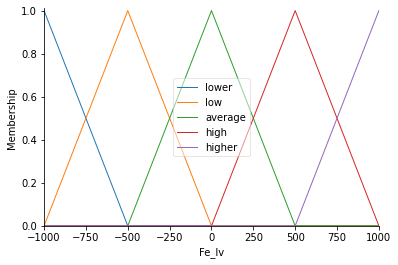

In [24]:
#Параметры моделирования системы
x_zad=250 # in m

#Сгенерировали нечёткую систему

#Fuzzy regulator parameters init
Fe_abs=1e3
Fe_min=-Fe_abs
Fe_max=Fe_abs

# New Antecedent/Consequent objects hold universe variables and
# continues membership functions
N=1000 # count of point for universe
E_delta=0.25 # coefficient of reflaction x coordinate from x_zad in x_zad percentage 
E = ctrl.Antecedent(np.linspace(-x_zad*E_delta, x_zad, int(N+1)), 'E') # input in m with 
Phi_lv = ctrl.Antecedent(np.linspace(-40*math.pi/180, 40*math.pi/180, int(N+1)), 'Phi_lv') # in rad
Fe_lv = ctrl.Consequent(np.linspace(Fe_min, Fe_max, int(N+1)), 'Fe_lv')

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
cuant = ['lower','low','average','high','higher']
cuantE = ['NEAR','FAR']
E[cuantE[0]] = fuzz.trimf(E.universe, [-E_delta*x_zad, 0, E_delta*x_zad])
E[cuantE[1]] = fuzz.trapmf(E.universe, [0,x_zad*E_delta,x_zad,x_zad])
# Auto-membership function population 
Phi_lv.automf(5,'cuant')
Fe_lv.automf(5,'cuant')

E.view()
Phi_lv.view()
Fe_lv.view()

#создание базы правил нечеткой системы
#Fuzzy rules
rule1 = ctrl.Rule(Phi_lv[cuant[0]] & E[cuantE[0]] , Fe_lv[cuant[4]])
rule2 = ctrl.Rule(Phi_lv[cuant[1]] & E[cuantE[0]], Fe_lv[cuant[3]])
rule3 = ctrl.Rule(Phi_lv[cuant[2]] & E[cuantE[0]], Fe_lv[cuant[2]])
rule4 = ctrl.Rule(Phi_lv[cuant[3]] & E[cuantE[0]], Fe_lv[cuant[1]])
rule5 = ctrl.Rule(Phi_lv[cuant[4]] & E[cuantE[0]], Fe_lv[cuant[0]])
rule6 = ctrl.Rule(E[cuantE[1]], Fe_lv[cuant[4]])

#Control System Creation 
sys_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4 , rule5, rule6])
sys_sim = ctrl.ControlSystemSimulation(sys_ctrl)


In [38]:


# Define the time and input vectors
time_start_force=0
T_N=int(1e3+1) #points for simulation
time_interval_stop = 40 # length of time interval in sec 
time_application_of_force = 5
T = np.linspace(0, time_interval_stop, (T_N))
dt= time_interval_stop/(T_N-1) # time step
N_time_start_force = math.ceil((time_start_force/time_interval_stop)*(T_N))
#Fe_en=np.concatenate( ( np.zeros(N_time_start_force), np.ones(T_N-N_time_start_force) ) )
#Fe = np.array([0])

N_time_application_of_force = math.ceil((time_application_of_force/time_interval_stop)*(T_N))
Fe = 3e3*np.concatenate(( np.zeros(N_time_start_force),
            np.ones(N_time_application_of_force),
            np.zeros(len(T)-N_time_start_force-N_time_application_of_force) ))


In [26]:
#Input/ouput model for the object
sys_object = ct.NonlinearIOSystem(port_crane_updfcn, port_crane_outfcn, 
                   inputs = ('Fe'), outputs = None, states=('x','dx','phi','dphi'),
                   name='sys_object',params={})

In [34]:
#file iosys.py

# controlsystem
'''
def _rhs(self, t, x, u, params={}):
  NotImplemented("Evaluation not implemented for system of type ",
                  type(self))
  
  '''
      * _rhs(t, x, u): compute the right hand side of the differential or
      difference equation for the system.  This must be specified by the
      subclass for the system.
    * _out(t, x, u): compute the output for the current state of the system.
      The default is to return the entire system state.

    def linearize(self, x0, u0, t=0, params={}, eps=1e-6,
                  name=None, copy=False, **kwargs):
        """Linearize an input/output system at a given state and input.
        Return the linearization of an input/output system at a given state
        and input value as a StateSpace system.  See
        :func:`~control.linearize` for complete documentation.
        """
        #
        # If the linearization is not defined by the subclass, perform a
        # numerical linearization use the `_rhs()` and `_out()` member
        # functions.
      '''
'''
'''
#realise
def _rhs(self, t, x, u):
  # Convert input to column vector and then change output to 1D array
  xdot = np.dot(self.A, np.reshape(x, (-1, 1))) \
      + np.dot(self.B, np.reshape(u, (-1, 1)))
  return np.array(xdot).reshape((-1,))

def _out(self, t, x, u):
  # Convert input to column vector and then change output to 1D array
  y = np.dot(self.C, np.reshape(x, (-1, 1))) \
      + np.dot(self.D, np.reshape(u, (-1, 1)))
  return np.array(y).reshape((-1,))

def dynamics(self, t, x, u):
  return self._rhs(t, x, u)
        
  
def _out(self, t, x, u, params={}):
  return x




#nonlinearsystem

def _rhs(self, t, x, u):
    xdot = self.updfcn(t, x, u, self._current_params) \
        if self.updfcn is not None else []
    return np.array(xdot).reshape((-1,))

def _out(self, t, x, u):
    y = self.outfcn(t, x, u, self._current_params) \
        if self.outfcn is not None else x
    return np.array(y).reshape((-1,))
'''
#input_output_response

def _check_convert_array(in_obj, legal_shapes, err_msg_start, squeeze=False,
                         transpose=False):
  # convert nearly everything to an array.
    out_array = np.asarray(in_obj)
    if (transpose):
        out_array = np.transpose(out_array)

    # Test element data type, elements must be numbers
    legal_kinds = set(("i", "f", "c"))  # integer, float, complex
    if out_array.dtype.kind not in legal_kinds:
        err_msg = "Wrong element data type: '{d}'. Array elements " \
                  "must be numbers.".format(d=str(out_array.dtype))
        raise TypeError(err_msg_start + err_msg)

    # If array is zero dimensional (in_obj is scalar):
    # create array with legal shape filled with the original value.
    if out_array.ndim == 0:
        for s_legal in legal_shapes:
            # search for shape that does not contain the special symbol any.
            if "any" in s_legal:
                continue
            the_val = out_array[()]
            out_array = np.empty(s_legal, 'd')
            out_array.fill(the_val)
            break

    # Test shape
    def shape_matches(s_legal, s_actual):
        """Test if two shape tuples match"""
        # Array must have required number of dimensions
        if len(s_legal) != len(s_actual):
            return False
        # All dimensions must contain required number of elements. Joker: "all"
        for n_legal, n_actual in zip(s_legal, s_actual):
            if n_legal == "any":
                continue
            if n_legal != n_actual:
                return False
        return True

    # Iterate over legal shapes, and see if any matches out_array's shape.
    for s_legal in legal_shapes:
        if shape_matches(s_legal, out_array.shape):
            break
    else:
        legal_shape_str = " or ".join([str(s) for s in legal_shapes])
        err_msg = "Wrong shape (rows, columns): {a}. Expected: {e}." \
                  .format(e=legal_shape_str, a=str(out_array.shape))
        raise ValueError(err_msg_start + err_msg)

    # Convert shape
    if squeeze:
        out_array = np.squeeze(out_array)
        # We don't want zero dimensional arrays
        if out_array.shape == tuple():
            out_array = out_array.reshape((1,))

    return out_array

def _update_params(self, params, warning=False):
  # Update the current parameter values
  self._current_params = self.params.copy()
  self._current_params.update(params)

def _process_time_response(
        sys, tout, yout, xout, transpose=None, return_x=False,
        squeeze=None, input=None, output=None):
      # If squeeze was not specified, figure out the default (might remain None)
    if squeeze is None:
        squeeze = config.defaults['control.squeeze_time_response']

    # Determine if the system is SISO
    issiso = sys.issiso() or (input is not None and output is not None)

    # Figure out whether and how to squeeze output data
    if squeeze is True:         # squeeze all dimensions
        yout = np.squeeze(yout)
    elif squeeze is False:      # squeeze no dimensions
        pass
    elif squeeze is None:       # squeeze signals if SISO
        if issiso:
            if len(yout.shape) == 3:
                yout = yout[0][0]       # remove input and output
            else:
                yout = yout[0]          # remove input
    else:
        raise ValueError("unknown squeeze value")

    # Figure out whether and how to squeeze the state data
    if issiso and xout is not None and len(xout.shape) > 2:
        xout = xout[:, 0, :]            # remove input

    # See if we need to transpose the data back into MATLAB form
    if transpose:
        # Transpose time vector in case we are using np.matrix
        tout = np.transpose(tout)

        # For signals, put the last index (time) into the first slot
        yout = np.transpose(yout, np.roll(range(yout.ndim), 1))
        if xout is not None:
            xout = np.transpose(xout, np.roll(range(xout.ndim), 1))

    # Return time, output, and (optionally) state
    return (tout, yout, xout) if return_x else (tout, yout)

def input_output_response(
        sys, T, U=0., X0=0, params={},
        transpose=False, return_x=False, squeeze=None,
        solve_ivp_kwargs={}, **kwargs):
  """Compute the output response of a system to a given input.'''
  """

  # Set the default method to 'RK45'
  if solve_ivp_kwargs.get('method', None) is None:
    solve_ivp_kwargs['method'] = 'RK45'

  # Compute the time interval and number of steps
  T0, Tf = T[0], T[-1]
  n_steps = len(T)  

  # Check and convert the input, if needed
  # TODO: improve MIMO ninputs check (choose from U)
  if sys.ninputs is None or sys.ninputs == 1:
      legal_shapes = [(n_steps,), (1, n_steps)]
  else:
      legal_shapes = [(sys.ninputs, n_steps)]
  U = _check_convert_array(U, legal_shapes,
                            'Parameter ``U``: ', squeeze=False)

  # Check to make sure this is not a static function
  nstates = _find_size(sys.nstates, X0)

  # create X0 if not given, test if X0 has correct shape
  X0 = _check_convert_array(X0, [(nstates,), (nstates, 1)],
                            'Parameter ``X0``: ', squeeze=True)

  # Update the parameter values
  sys._update_params(params)

  def ufun(t):
  # Find the value of the index using linear interpolation
    idx = np.searchsorted(T, t, side='left')
    if idx == 0:
      # For consistency in return type, multiple by a float
      return U[..., 0] * 1.
    else:
      dt = (t - T[idx-1]) / (T[idx] - T[idx-1])
      return U[..., idx-1] * (1. - dt) + U[..., idx] * dt

  # Create a lambda function for the right hand side
  def ivp_rhs(t, x):
    return sys._rhs(t, x, ufun(t))

  if not hasattr(sp.integrate, 'solve_ivp'):
    raise NameError("scipy.integrate.solve_ivp not found; "
                        "use SciPy 1.0 or greater")
    soln = sp.integrate.solve_ivp(
        ivp_rhs, (T0, Tf), X0, t_eval=T,
        vectorized=False, **solve_ivp_kwargs)

    # Compute the output associated with the state (and use sys.out to
    # figure out the number of outputs just in case it wasn't specified)
    u = U[0] if len(U.shape) == 1 else U[:, 0]
    y = np.zeros((np.shape(sys._out(T[0], X0, u))[0], len(T)))
    for i in range(len(T)):
        u = U[i] if len(U.shape) == 1 else U[:, i]
        y[:, i] = sys._out(T[i], soln.y[:, i], u)

  return _process_time_response(sys, soln.t, y, soln.y, transpose=transpose,
                                  return_x=return_x, squeeze=squeeze)



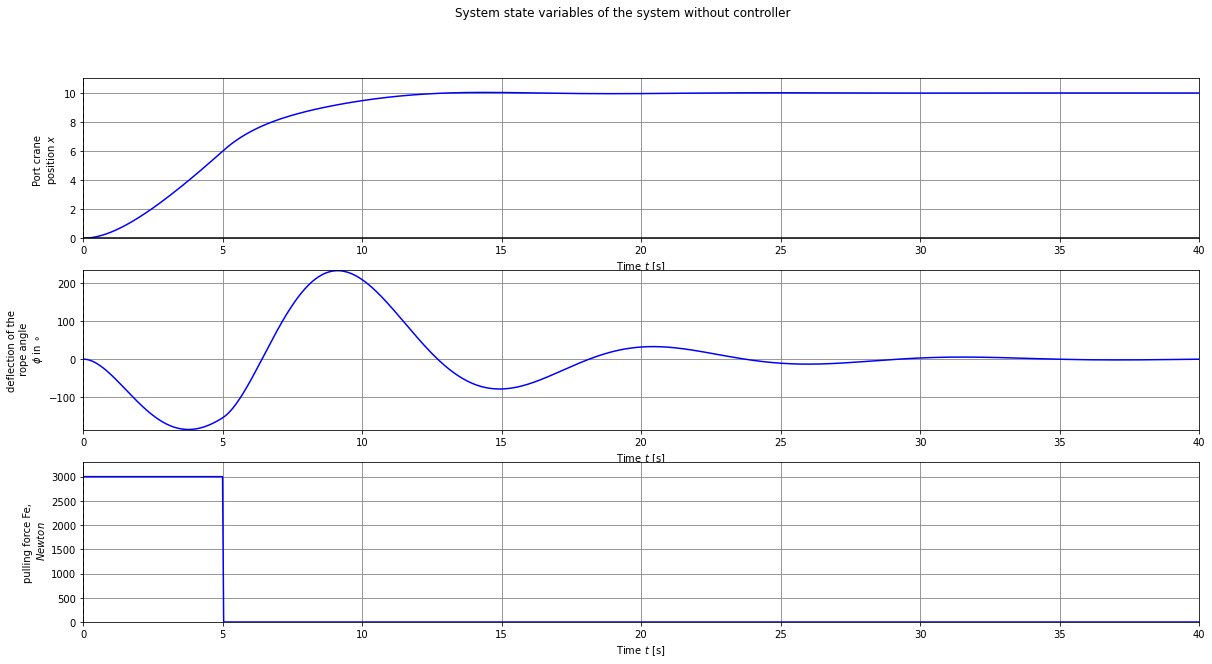

In [47]:
# Define the generator for simulating an system with Fuzzy-controller


#sys_state=[0,0,0,0]


sys_state = np.array([[0],[0],[0],[0]]) # array for state variables of the object size=(4,TN+1) =[x,dx,phi,dphi]^T where dx ... ddphi are vectors
temporary_state = np.array([[0],[0],[0],[0]])

t, sys_state = ct.input_output_response(sys_object, T, [Fe],sys_state.T[0],params={})
'''
i=0
for i in range(len(T)-1):
    #sys_sim.input['E'] = x_zad-sys_state[0,i]
    #sys_sim.input['Phi_lv'] = sys_state[2,i]
    #sys_sim.compute()

    #Fe=np.append( Fe ,   sys_sim.output['Fe_lv']  )
    #Fe=np.append( Fe , [1e3] )
    #if i==0:
    #temporary_state = np.array(  [ (sys_object.output(T[i], sys_object.dynamics(T[i], sys_state[0:4,i], [Fe[i]]) , [Fe[i]])) ]  ).T
    #else:    
    
    def ufun(t):
      # Find the value of the index using linear interpolation
      idx = np.searchsorted(T, t, side='left')
      if idx == 0:
          # For consistency in return type, multiple by a float
          return U[..., 0] * 1.
      else:
          dtk = (t - T[idx-1]) / (T[idx] - T[idx-1])
          return U[..., idx-1] * (1. - dtk) + U[..., idx] * dtke    

    if i==0:
      temporary_state = np.array(  [ dt*(sys_object.dynamics(T[i], sys_state[0:4,i], [Fe[i]])) ]  ).T
    else:
      temporary_state = np.array(  [ dt*(sys_object.dynamics(T[i], sys_state[0:4,i], [Fe[i]])) ]  + sys_state[0:4,i-1] ).T
    
    #temporary_state = np.array(  [ (sys_object._rhs(T[i], sys_state[0:4,i], [Fe[i]])) ]  ).T
    sys_state=np.append( sys_state,   temporary_state  , axis=1)
    '''
    
#create graphics
figsize=(20,10)
plt.figure(figsize=figsize)  
subplots = system_dynamic_plot(sys_object, T, y_sfb, u=Fe,
         t_start_input=time_start_force, linetype='-b',fig_size=figsize)

# Add title and legend
plt.suptitle('System state variables of the system without controller')
import matplotlib.lines as mlines
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='without controller')

In [194]:
print((Fe.size),"-----",(T.size))

30001 ----- 10001


In [45]:
print(sys_state.T[0])

[0 0 0 0]


In [188]:
print([  sys_sim.output['Fe_lv']  ])

[4166.666666666665]


In [132]:
print(sys_state)

[[0 0]
 [0 0]
 [0 0]
 [0 0]]


In [ ]:
print(sys_object.dynamics(t, sys_state[0:4,sys_state.shape[1]-3:sys_state.shape[1]-1], [Fe[Fe.size-3:Fe.size-1]]))

TypeError: ignored

In [ ]:
print(sys_state)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(t)
print(((t/T)*(len(T)-1)))

0.0
[nan  0.  0. ...  0.  0.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [129]:
#emporary_state = np.array([[0],[0],[8],[0]])
print(temporary_state)

[0 0 0 0]


In [ ]:
a=np.array([5])
a=np.append(a,3)
print(a)
a=np.append(a,8)
print(a[2])

[5 3]
8


In [ ]:
a=np.array([[3 ,4 ,5],[4,6,8]])
print(a[0:2,1])
print(a[:end])
print(len(a))

[4 6]


NameError: ignored

In [ ]:

print(ddx[0].evalf(subs={ 'x':3,'dx':2,'phi':2,'dphi':2,'m':230,'M':6000,'k1':0,'k2':0,'g':9.8,'L':30,'Fe':800 }))

2.14258499040039


In [ ]:
type(a)

sympy.core.add.Add

In [ ]:
def port_crane_outdcn(t ,x ,u , param={})
  # Get the port crane parameters that we need
  